# Burgers' equation physics-informed neural network (PINN)


Raissi et al, Physics-informed neural networks: 
A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations, JCP (2018)

https://arxiv.org/pdf/1711.10561



## Problem overview



Consider the one dimensional viscous Burgers' equation: 

$$ \frac{\partial
u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2
u}{\partial x^2} = 0 $$

In one space dimension, the Burgers equation along with Dirichlet boundary
conditions reads as:

$$ u(x, 0) = -\sin(\pi x) $$ 
$$ u(-1, t) = u(+1, t) = 0 $$


And viscosity (v) as:

𝜈 =0.01/𝜋

This equation arises in various areas of applied mathematics, including uid
mechanics, nonlinear acoustics, gas dynamics, and traffic flow. It is a
fundamental partial diferential equation and can be derived from the
Navier-Stokes equations for the velocity eld by dropping the pressure gradient
term.

Using the same number of hidden layers, neurons per layer, number of training
and collocation points as is described in the paper:

- 𝑁f=10,000 (Latin hypercube sampling)  - collocation points - 
- Nu = 100 (boundary points)
- Fully connected network with 9 layers, 20 hidden units (3021 free parameters) 
- Hyperbolic tangent activation function 
- L-BFGS optimiser

## Calculate the loss

### Initial condition

From the initial condition: 

$$ u(x, 0) = -\sin(\pi x) $$

We calculate the first term of the boundary loss:

$$ L_b(\theta)_1 = \frac{\lambda_1}{N_{b1}} \sum_{i}^{N_{b1}} \left( NN(x_i, 0; \theta) + \sin(\pi x_i) \right)^2 $$

### Boundary condition 1

From the boundary condition for _x=-1_

$$ u(-1, t) = 0 $$

We calculate the second term of the boundary loss:

$$ L_b(\theta)_2 =\frac{\lambda_2}{N_{b2}} \sum_{k}^{N'_{b2}} \left( NN(-1, t_k; \theta) - 0 \right)^2 $$


### Boundary condition 2

From the boundary condition for _x=1_

$$ u(+1, t) = 0 $$

We calculate the third term of the boundary loss:

$$ L_b(\theta)_3 = \frac{\lambda_3}{N_{b3}} \sum_{i}^{N_{b3}} \left( NN(+1, t_i; \theta) - 0 \right)^2 $$


### Boundary loss

$$ 
L_b(\theta) = \frac{\lambda_1}{N_{b1}} \sum_{i}^{N_{b1}} \left( NN(x_i, 0; \theta) + \sin(\pi x_i) \right)^2 
+ \frac{\lambda_2}{N_{b2}} \sum_{k}^{N'_{b2}} \left( NN(-1, t_k; \theta) - 0 \right)^2 
+  \frac{\lambda_3}{N_{b3}} \sum_{i}^{N_{b3}} \left( NN(+1, t_i; \theta) - 0 \right)^2

$$



### Physics loss

From the equation: 

$$ \frac{\partial
u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2
u}{\partial x^2} = 0 $$

The physics loss function is defined by:

$$
L_p(\theta) = \frac{1}{N_p} \sum_{i}^{N_p} \left( \left( \frac{\partial NN}{\partial t} + NN \frac{\partial NN}{\partial x} - v \frac{\partial^2 NN}{\partial x^2} \right) (x_i, t_i; \theta) \right)^2
$$


The underlying differential equation ("physics loss") in the loss function,
ensure that the learned solution is consistent with the underlying differential
equation. 

In [1]:
from PIL import Image

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

## Define the training points

First, let's define the training points, the initial condition points, the boundary collocation points, and the interior collocation points. The variable names for the boundary condition points reflect their positions relative to the image below:

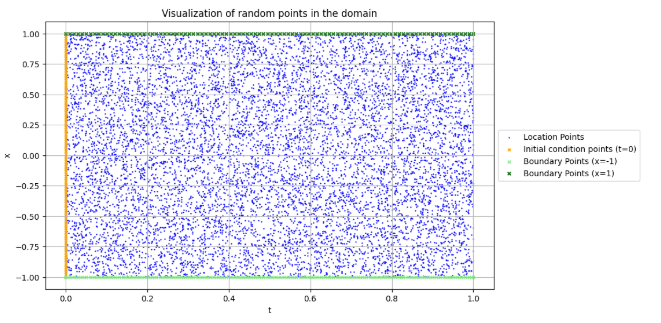


- `(t_initial, x_initial)` represents the initial condition points, shown in orange. 
- `(t_boundary, x_bottom)` corresponds to the light green points at x = -1 
- `(t_boundary, x_top)` to the dark green points at x = 1, 


- `(x_physics, t_physics)` points are the points sampled from the domain, that help us to penalise the residual of the differential equations.


In [2]:
# Initial condition points(100 points) (t=0, x in [-1, 1])
# Orange points in the graph above
x_initial = torch.linspace(-1, 1, 100).reshape(-1, 1) # 100 points spread uniformly across the interval [-1, 1].
t_initial = torch.zeros_like(x_initial)                       # t=0
u_initial = -torch.sin(torch.pi * x_initial)                  # u(0,x)=-sin(pi*x)

# for both boundaries (x=-1, t in [0, 1]) and (x=1, t in [0, 1])
t_boundary = torch.linspace(0, 1, 100).reshape(-1, 1)  # 100 points spread uniformly across the interval [0, 1].

# Boundary condition (x=-1, t in [0, 1])
# light green points in the graph above
x_bottom = -torch.ones_like(t_boundary)   # x = -1
u_bottom = torch.zeros_like(t_boundary)   # u(-1,t) = 0

# Boundary condition (x=1, t in [0, 1])
# (same t_boundary)
# dark green points in the graph above
x_top = torch.ones_like(t_boundary)   # x = 1
u_top = torch.zeros_like(t_boundary)  # u(1,t) = 0

# Physics loss points (x in [-1, 1], t in [0, 1]) (location points)
# Blue points in the graph above
x_physics = torch.rand(10000, 1) * 2 - 1  # random points in [-1, 1]
t_physics = torch.rand(10000, 1) * 1      # random points in [0, 1]

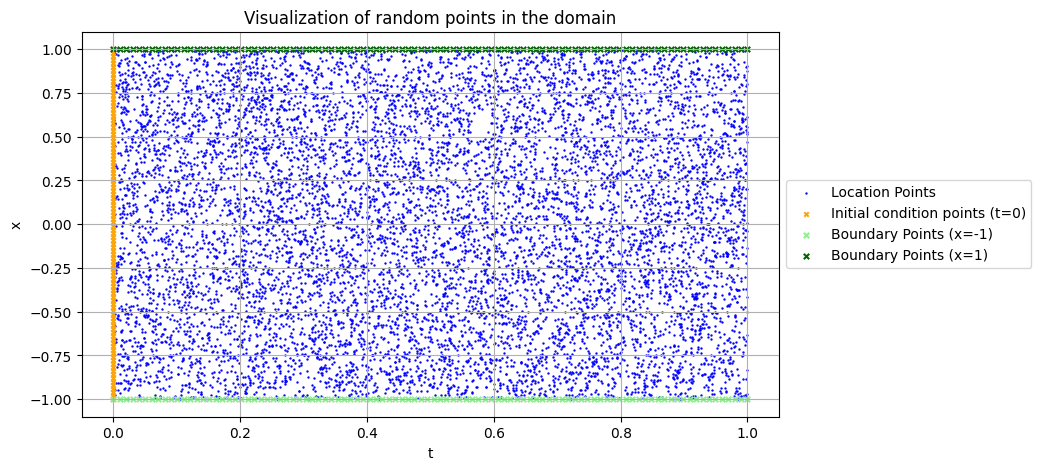

In [3]:
# Plot the points (generate the graph that you saw above)
plt.figure(figsize=(9, 5))

# Plot domain/location points
plt.scatter(t_physics, x_physics, s=0.5, c="blue", label="Location Points")

# # Plot boundary points
plt.scatter(t_initial, x_initial, s=10, label="Initial condition points (t=0)", c= "orange", marker='x')
plt.scatter(t_boundary, x_bottom, s=15, label="Boundary Points (x=-1)", c="lightgreen", marker='x')
plt.scatter(t_boundary, x_top, s=15, label="Boundary Points (x=1)", c="darkgreen",  marker='x')

# Add labels and legend
plt.title("Visualization of random points in the domain")
plt.xlabel("t")
plt.ylabel("x")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

<!--  -->


## Define the Neural Network


In [4]:
# This class will help us to define the Full connected Neural Network for the PINN

class FCN(nn.Module):
    "Defines a connected network"    
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh #Activation function to use.
        self.input_layer = nn.Sequential(nn.Linear(n_input,n_hidden),activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden,n_hidden),activation()) for _ in range(n_layers-1)])
        self.output_layer = nn.Sequential(nn.Linear(n_hidden,n_output))
        
    def forward(self, t, x):
        x = torch.cat([t, x], dim=1)
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)        
        return x

In [ ]:
torch.manual_seed(123)

# We define the model, with 2 inputs (t and x), 1 output (u), 20 hidden neurons and 9 layers 
# (as described in the paper refered at the beggining of the notebook)

model = FCN(n_input=2, n_output=1, n_hidden=20, n_layers=9)

# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

`requires_grad = True` 

pytorch, by default, doesn't track the computation graph, for efficiency.
but we want, so we need explicitely to say, which gradients, with respect to this sensor which we do.


so we're going to do that and then we're going to just make sure that it's a nice shape for the input of the network so it so remember the network in pi to watch has a batch Dimension here

now, colocation points for the physics loss.

here we will have points for the whole domain:

In [6]:
# linspace(0,1,30) ->  This function generates a sequence of 30 evenly spaced values between 0 and 1.

# .view(-1, 1) ->  reshapes the tensor into a 2-dimensional tensor with 30 rows and 1 column.
# The -1 argument means that the number of rows is inferred from the length of the tensor, and 1 specifies the number of columns.

# .requires_grad_(True) -> gradients should be computed for this tensor during the backward pass.
#  used  in optimization problems and neural network training where you need to compute gradients for updating parameters.

# x_physics = torch.linspace(0,1,30, requires_grad=True).view(-1,1) # sample locations over the problem domain

**boundary loss 2**

`autograd` is not actually computing the jacobian.
it's computing the vector Jacobian product, when we are using reverse mode.
So we need also to define what the vector is, what we are applying to that jacobian vector product, 

`torch.ones_like(yhp)` 

` dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx`

`loss2 = torch.sqeeze((dx-0) ** 2)` 



physics loss (loss 3)



In [7]:
# viscosity constant
v = 0.01/np.pi

In [8]:
# I'm going to save all the losses, for drawing them later:
total_losses = []

initial_condition_losses = []
boundary_condition_losses = []
physics_losses = []

`Require gradients` is used in scenarios where you need to update model parameters based on computed gradients.
By default the differentiated Tensors does not require gradients (for performance reasons),
but we need to compute the gradients of the loss with respect to the inputs (t_physics, x_physics) during the training process.
So enable the gradient tracking for these tensors is crucial for allowing PyTorch to compute gradients during the backward pass.

In [9]:
t_physics.requires_grad_(True)
x_physics.requires_grad_(True)

tensor([[ 0.0288],
        [-0.9728],
        [-0.2408],
        ...,
        [-0.5683],
        [-0.0885],
        [ 0.5555]], requires_grad=True)

## Training Loop

In [11]:
for i in range(20000):
    lambda1, lambda2, lambda3 = 1e-1, 1e-4, 1e-4

    def closure():
        optimizer.zero_grad()
        
        # compute the boundary loss (initial condition), or Temporal boundary residual
        u_predicted = model(t_initial, x_initial)   
        loss_initial_condition = torch.mean((u_initial - u_predicted) ** 2)

        # compute the boundary loss (boundary conditions) or Spatial boundary residual
        u_bottom_pred = model(t_boundary, x_bottom)  # bottom x=-1
        u_top_pred = model(t_boundary, x_top)        # top x=1
        loss_boundary = torch.mean((u_bottom - u_bottom_pred) ** 2) + torch.mean((u_top - u_top_pred) ** 2)    

        # compute the physics loss or interior residual of the PDE
        u_physics = model(t_physics, x_physics)

        # Using PyTorch's autograd to compute derivatives of the network's output (u_physics) 
        # with respect to its input variables (t_physics and x_physics). These derivatives are 
        # essential for calculating the residual of the Burgers' equation, which forms the 
        # physics loss term in the training process.

        # computes dy/dt (first derivative of u with respect to t)
        du_physics_t  = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0]

        # computes dy/dx (first derivative of u with respect to x)
        du_physics_x  = torch.autograd.grad(u_physics, x_physics, torch.ones_like(u_physics), create_graph=True)[0]

        # computes d^2y/dx^2 (second derivative of u with respect to x)
        du2_physics = torch.autograd.grad(du_physics_x,  x_physics, torch.ones_like(u_physics),  create_graph=True)[0]
        
        # computes the residual of differential equation (physics loss)
        loss_physics = torch.mean((du_physics_t + u_physics * du_physics_x - v * du2_physics)** 2) 
            
        # add three loss (initial, boundary and physics) terms together
        loss = lambda1 * loss_initial_condition + lambda2 * loss_boundary + lambda3 * loss_physics  
        
        # backpropagate the joint loss
        loss.backward()

        # save the losses (for plotting later)
        total_losses.append(loss.item())
        initial_condition_losses.append(loss_initial_condition.item())
        boundary_condition_losses.append(loss_boundary.item())
        physics_losses.append(loss_physics.item())

        return loss

    # Perform optimization step
    optimizer.step(closure)

    # print the loss every 1000 iterations to check the progress
    if (i+1) % 1000 == 0: 
        current_loss = total_losses[-1]
        print(f"Iteration {i+1}: \n \
              - Total loss = {current_loss} \n \
              - Initial Condition Loss = {initial_condition_losses[-1]} \n \
              - Boundary Condition Loss = {boundary_condition_losses[-1]} \n \
              - Physics Loss = {physics_losses[-1]}")



Iteration 1000: 
               - Total loss = 3.572686910047196e-05 
               - Initial Condition Loss = 1.0587220458546653e-05 
               - Boundary Condition Loss = 0.0018952999962493777 
               - Physics Loss = 0.3447861671447754
Iteration 2000: 
               - Total loss = 3.572686910047196e-05 
               - Initial Condition Loss = 1.0587220458546653e-05 
               - Boundary Condition Loss = 0.0018952999962493777 
               - Physics Loss = 0.3447861671447754
Iteration 3000: 
               - Total loss = 3.572686910047196e-05 
               - Initial Condition Loss = 1.0587220458546653e-05 
               - Boundary Condition Loss = 0.0018952999962493777 
               - Physics Loss = 0.3447861671447754
Iteration 4000: 
               - Total loss = 3.572686910047196e-05 
               - Initial Condition Loss = 1.0587220458546653e-05 
               - Boundary Condition Loss = 0.0018952999962493777 
               - Physics Loss = 0.34478

These screenshots, taken from the paper, shows the predicted solution u(t, x) alongside the initial and boundary training data:

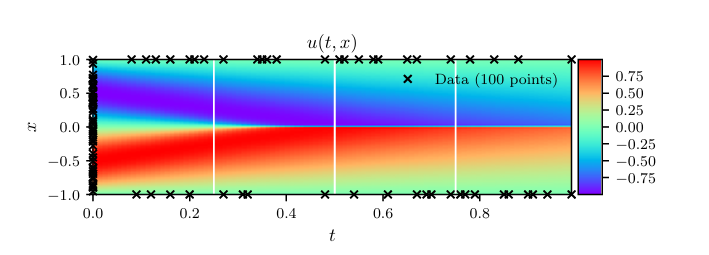

and the comparison of the predicted solution in the paper and the exact solution corresponding to the temporal snapshots: t=0.25, t=0.50 and t=0.75.

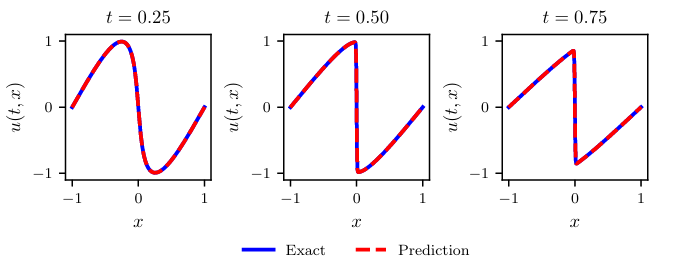


In [12]:
# prepare data for the plots

t = np.linspace(0, 1, 100)
x = np.linspace(-1, 1, 200)
T, X = np.meshgrid(t, x)

t_test = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32)
x_test = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32)
u_pred = model(t_test, x_test).detach().numpy().reshape(200, 100)

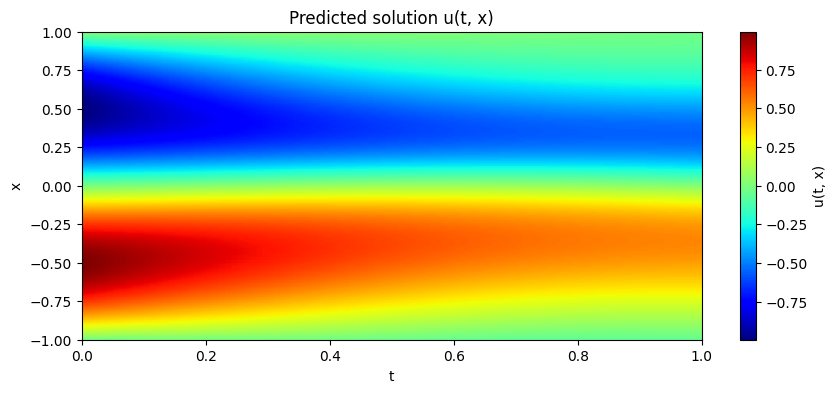

In [13]:
#A heatmap of the predicted solution u(t, x) over the domain t ∈ [0, 1], x ∈ [-1, 1].
def plot_heatmap():
    plt.figure(figsize=(10, 4))
    plt.imshow(u_pred, extent=[0, 1, -1, 1], origin='lower', aspect='auto', cmap='jet')
    plt.colorbar(label='u(t, x)')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Predicted solution u(t, x)')
    plt.savefig('Burgers_predicted_sol_withbound.png')
    plt.show()

plot_heatmap()

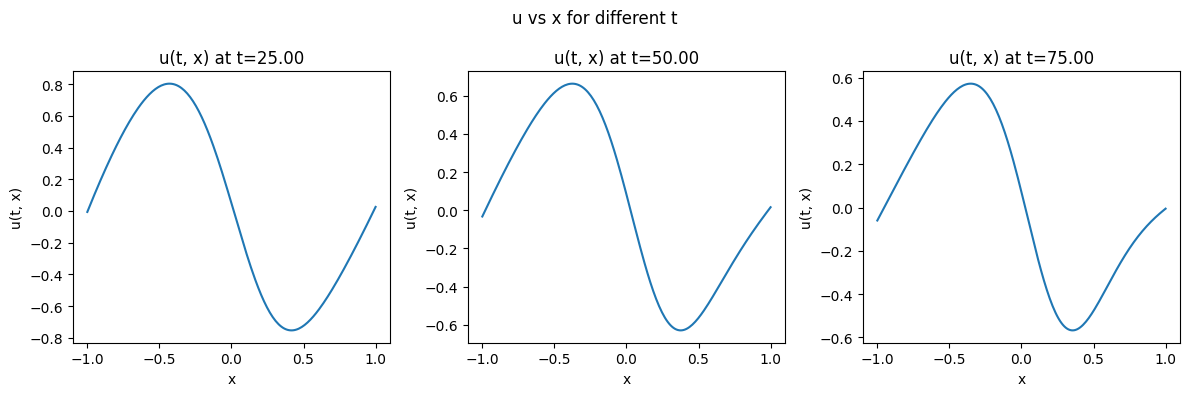

In [14]:
#Functions to have plots
#A heatmap of the predicted solution u(t, x) over the domain t ∈ [0, 1], x ∈ [-1, 1].
def plot_temp_snapshot():
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, time in enumerate([25, 50, 75]):
        axs[i].plot(x, u_pred[:, time], label=f't={time/100:.2f}')
        axs[i].set_title(f'u(t, x) at t={time:.2f}')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('u(t, x)')

    fig.suptitle('u vs x for different t')
    plt.tight_layout()
    plt.show()

plot_temp_snapshot()

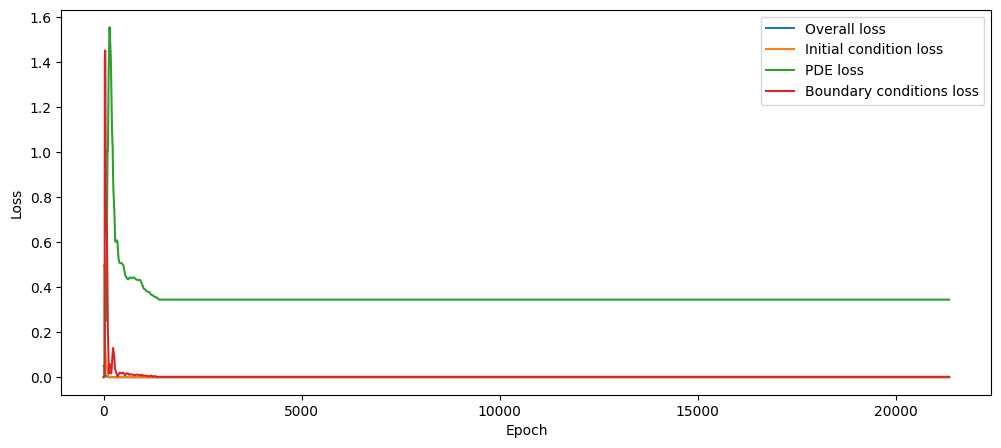

In [15]:
# A plot of the total loss over training epochs 
plt.figure(101, figsize=(12, 5))
plt.plot(total_losses, label="Overall loss")
plt.plot(initial_condition_losses, label="Initial condition loss")
plt.plot(physics_losses, label="PDE loss")
plt.plot(boundary_condition_losses, label="Boundary conditions loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()